# Lesson 3  
**Get Data** - Our data set will consist of an Excel file containing customer counts per date. We will learn how to read in the excel file for processing.  
**Prepare Data** - The data is an irregular time series having duplicate dates. We will be challenged in compressing the data and coming up with next years forecasted customer count.  
**Analyze Data** - We use graphs to visualize trends and spot outliers. Some built in computational tools will be used to calculate next years forecasted customer count.  
**Present Data** - The results will be plotted.  

***NOTE:
Make sure you have looked through all previous lessons, as the knowledge learned in previous lessons will be
needed for this exercise.***

In [87]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy.random as np
import sys

%matplotlib inline

In [88]:
print 'Python version ' + sys.version
print 'Pandas version: ' + pd.__version__

Python version 2.7.10 |Anaconda 2.3.0 (64-bit)| (default, May 28 2015, 16:44:52) [MSC v.1500 64 bit (AMD64)]
Pandas version: 0.16.2


We will be creating our own test data for analysis.

In [89]:
# set seed
np.seed(111)

# Function to generate test data
def CreateDataSet(Number=1):
    
    Output = []
    
    for i in range(Number):
        
        # Create a weekly (mondays) date range
        rng = pd.date_range(start='1/1/2009', end='12/31/2012', freq='W-MON')
        
        # Create random data
        data = np.randint(low=25,high=1000,size=len(rng))
        
        # Status pool
        status = [1,2,3]
        
        # Make a random list of statuses
        random_status = [status[np.randint(low=0,high=len(status))] for i in range(len(rng))]
        
        # State pool
        states = ['GA','FL','fl','NY','NJ','TX']
        
        # Make a random list of states 
        random_states = [states[np.randint(low=0,high=len(states))] for i in range(len(rng))]
    
        Output.extend(zip(random_states, random_status, data, rng))
        
    return Output

Now that we have a function to generate our test data, lets create some data and stick it into a dataframe.

In [90]:
pd.date_range?

In [91]:
dataset = CreateDataSet(4)
df = pd.DataFrame(data=dataset, columns=['State','Status','CustomerCount','StatusDate'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 836 entries, 0 to 835
Data columns (total 4 columns):
State            836 non-null object
Status           836 non-null int64
CustomerCount    836 non-null int64
StatusDate       836 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 32.7+ KB


In [92]:
df.head()

,State,Status,CustomerCount,StatusDate
0,GA,1,877,2009-01-05
1,FL,1,901,2009-01-12
2,fl,3,749,2009-01-19
3,FL,3,111,2009-01-26
4,GA,1,300,2009-02-02


We are now going to save this dataframe into an Excel file, to then bring it back to a dataframe. We simply do this to show you how to read and write to Excel files.  

We do not write the index values of the dataframe to the Excel file, since they are not meant to be part of our initial test data set.

In [93]:
# Save results to excel
df.to_excel('Lesson3.xlsx', index=False)
print 'Done'

Done


# Grab Data from Excel  

We will be using the ***read_excel*** function to read in data from an Excel file. The function allows you to read in specfic tabs by name or location.

In [94]:
pd.read_excel?

**Note: The location on the Excel file will be in the same folder as the notebook, unless specified otherwise.**

In [95]:
# Location of file
Location = r'Lesson3.xlsx'

# Parse a specific sheet
df = pd.read_excel(Location, 0, index_col='StatusDate')
df.dtypes

State            object
Status            int64
CustomerCount     int64
dtype: object

In [96]:
df.index

DatetimeIndex(['2009-01-05', '2009-01-12', '2009-01-19', '2009-01-26',
               '2009-02-02', '2009-02-09', '2009-02-16', '2009-02-23',
               '2009-03-02', '2009-03-09', 
               ...
               '2012-10-29', '2012-11-05', '2012-11-12', '2012-11-19',
               '2012-11-26', '2012-12-03', '2012-12-10', '2012-12-17',
               '2012-12-24', '2012-12-31'],
              dtype='datetime64[ns]', name=u'StatusDate', length=836, freq=None, tz=None)

In [97]:
df.head()

,State,Status,CustomerCount
StatusDate,,,
2009-01-05,GA,1,877
2009-01-12,FL,1,901
2009-01-19,fl,3,749
2009-01-26,FL,3,111
2009-02-02,GA,1,300


# Prepare Data  

This section attempts to clean up the data for analysis.  
1. Make sure the state column is all in upper case  
2. Only select records where the account status is equal to "1"  
3. Merge (NJ and NY) to NY in the state column  
4. Remove any outliers (any odd results in the data set)


Lets take a quick look on how some of the *State* values are upper case and some are lower case

In [98]:
df['State'].unique()

array([u'GA', u'FL', u'fl', u'TX', u'NY', u'NJ'], dtype=object)

#### Functions
Functions provide a way to encapsulate a particular computation and isolate the implementation from the rest of the program.

In [99]:
def square(x):
    return x*x
square(4)

16

#### Lambda functions
Lambda functions provide a succinct syntac for defining functions right where you need them.
Lambda function are "nameless"

In [100]:
(lambda x:x*x)(4)

16

To convert all the State values to upper case we will use the ***upper()*** function and the dataframe's ***apply*** attribute. The ***lambda*** function simply will apply the upper function to each value in the *State* column.

In [101]:
# Clean State Column, convert to upper case
df['State'] = df.State.apply(lambda x: x.upper())

In [102]:
df['State'].unique()

array([u'GA', u'FL', u'TX', u'NY', u'NJ'], dtype=object)

In [103]:
# Only grab where Status == 1
mask = df['Status'] == 1
df = df[mask]

To turn the ***NJ*** states to ***NY*** we simply...  

***[df.State == 'NJ']*** - Find all records in the *State* column where they are equal to *NJ*.  
***df.State[df.State == 'NJ'] = 'NY'*** - For all records in the *State* column where they are equal to *NJ*, replace them with *NY*.

In [104]:
# Convert NJ to NY
mask = df.State == 'NJ'
zip(df.State, mask)

[(u'GA', False),
 (u'FL', False),
 (u'GA', False),
 (u'NY', False),
 (u'FL', False),
 (u'NJ', True),
 (u'TX', False),
 (u'FL', False),
 (u'FL', False),
 (u'NJ', True),
 (u'GA', False),
 (u'FL', False),
 (u'NJ', True),
 (u'FL', False),
 (u'NJ', True),
 (u'FL', False),
 (u'NY', False),
 (u'FL', False),
 (u'NY', False),
 (u'TX', False),
 (u'FL', False),
 (u'NJ', True),
 (u'GA', False),
 (u'NY', False),
 (u'TX', False),
 (u'NY', False),
 (u'NJ', True),
 (u'TX', False),
 (u'NJ', True),
 (u'NJ', True),
 (u'NY', False),
 (u'FL', False),
 (u'FL', False),
 (u'GA', False),
 (u'NJ', True),
 (u'GA', False),
 (u'FL', False),
 (u'NJ', True),
 (u'TX', False),
 (u'FL', False),
 (u'NJ', True),
 (u'NJ', True),
 (u'TX', False),
 (u'GA', False),
 (u'FL', False),
 (u'FL', False),
 (u'NY', False),
 (u'NY', False),
 (u'NY', False),
 (u'TX', False),
 (u'FL', False),
 (u'FL', False),
 (u'FL', False),
 (u'NY', False),
 (u'FL', False),
 (u'GA', False),
 (u'TX', False),
 (u'TX', False),
 (u'GA', False),
 (u'GA', 

In [105]:
df['State'][mask] = 'NY'
df

,State,Status,CustomerCount
StatusDate,,,
2009-01-05,GA,1,877
2009-01-12,FL,1,901
2009-02-02,GA,1,300
2009-03-09,NY,1,992
2009-04-06,FL,1,291
2009-04-27,NY,1,753
2009-05-25,TX,1,46
2009-07-06,FL,1,723
2009-07-20,FL,1,710


Now we can see we have a much cleaner data set to work with.

In [106]:
df['State'].unique()

array([u'GA', u'FL', u'NY', u'TX'], dtype=object)

At this point we may want to graph the data to check for any outliers or inconsistencies in the data. We will be using the ***plot()*** attribute of the dataframe.  

As you can see from the graph below it is not very conclusive and is probably a sign that we need to perform some more data preparation.

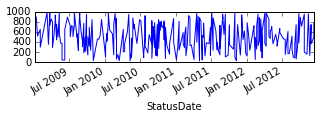

In [107]:
df['CustomerCount'].plot(figsize=(5,1));

If we take a look at the data, we begin to realize that there are multiple values for the same State, StatusDate, and Status combination. It is possible that this means the data you are working with is dirty/bad/inaccurate, but we will assume otherwise. We can assume this data set is a subset of a bigger data set and if we simply add the values in the ***CustomerCount*** column per State, StatusDate, and Status we will get the ***Total Customer Count*** per day.  

In [108]:
sortdf = df[df['State']=='NY'].sort(axis=0)
sortdf.head(10)

,State,Status,CustomerCount
StatusDate,,,
2009-01-19,NY,1,522
2009-02-23,NY,1,710
2009-03-09,NY,1,992
2009-03-16,NY,1,355
2009-03-23,NY,1,728
2009-03-30,NY,1,863
2009-04-13,NY,1,520
2009-04-20,NY,1,820
2009-04-20,NY,1,937


Our task is now to create a new dataframe that compresses the data so we have daily customer counts per State and StatusDate. We can ignore the Status column since all the values in this column are of value *1*. To accomplish this we will use the dataframe's functions ***groupby*** and ***sum()***.  

Note that we had to use **reset_index** . If we did not, we would not have been able to group by both the State and the StatusDate since the groupby function expects only columns as inputs. The **reset_index** function will bring the index ***StatusDate*** back to a column in the dataframe. 

In [109]:
df.columns

Index([u'State', u'Status', u'CustomerCount'], dtype='object')

In [110]:
# Group by State and StatusDate
Daily = df.reset_index().groupby(['State','StatusDate']).sum()
Daily.head()

Status  CustomerCount
State StatusDate                       
FL    2009-01-12       1            901
      2009-02-02       1            653
      2009-03-23       1            752
      2009-04-06       2           1086
      2009-06-08       1            649

The ***State*** and ***StatusDate*** columns are automatically placed in the index of the ***Daily*** dataframe. You can think of the ***index*** as the primary key of a database table but without the constraint of having unique values. Columns in the index as you will see allow us to easily select, plot, and perform calculations on the data.  

Below we delete the ***Status*** column since it is all equal to one and no longer necessary.

In [111]:
del Daily['Status']
Daily.head()

CustomerCount
State StatusDate               
FL    2009-01-12            901
      2009-02-02            653
      2009-03-23            752
      2009-04-06           1086
      2009-06-08            649

In [112]:
# What is the index of the dataframe
Daily.index

MultiIndex(levels=[[u'FL', u'GA', u'NY', u'TX'], [2009-01-05 00:00:00, 2009-01-12 00:00:00, 2009-01-19 00:00:00, 2009-02-02 00:00:00, 2009-02-23 00:00:00, 2009-03-09 00:00:00, 2009-03-16 00:00:00, 2009-03-23 00:00:00, 2009-03-30 00:00:00, 2009-04-06 00:00:00, 2009-04-13 00:00:00, 2009-04-20 00:00:00, 2009-04-27 00:00:00, 2009-05-04 00:00:00, 2009-05-11 00:00:00, 2009-05-18 00:00:00, 2009-05-25 00:00:00, 2009-06-08 00:00:00, 2009-06-22 00:00:00, 2009-07-06 00:00:00, 2009-07-13 00:00:00, 2009-07-20 00:00:00, 2009-07-27 00:00:00, 2009-08-10 00:00:00, 2009-08-17 00:00:00, 2009-08-24 00:00:00, 2009-08-31 00:00:00, 2009-09-07 00:00:00, 2009-09-14 00:00:00, 2009-09-21 00:00:00, 2009-09-28 00:00:00, 2009-10-05 00:00:00, 2009-10-12 00:00:00, 2009-10-19 00:00:00, 2009-10-26 00:00:00, 2009-11-02 00:00:00, 2009-11-23 00:00:00, 2009-11-30 00:00:00, 2009-12-07 00:00:00, 2009-12-14 00:00:00, 2010-01-04 00:00:00, 2010-01-11 00:00:00, 2010-01-18 00:00:00, 2010-01-25 00:00:00, 2010-02-08 00:00:00, 2010-

In [113]:
# Select the State index
Daily.index.levels[0]

Index([u'FL', u'GA', u'NY', u'TX'], dtype='object', name=u'State')

In [114]:
# Select the StatusDate index
Daily.index.levels[1]

DatetimeIndex(['2009-01-05', '2009-01-12', '2009-01-19', '2009-02-02',
               '2009-02-23', '2009-03-09', '2009-03-16', '2009-03-23',
               '2009-03-30', '2009-04-06', 
               ...
               '2012-09-24', '2012-10-01', '2012-10-08', '2012-10-22',
               '2012-10-29', '2012-11-05', '2012-11-12', '2012-11-19',
               '2012-11-26', '2012-12-10'],
              dtype='datetime64[ns]', name=u'StatusDate', length=161, freq=None, tz=None)

Lets now plot the data per State.  

As you can see by breaking the graph up by the ***State*** column we have a much clearer picture on how the data looks like. Can you spot any outliers?

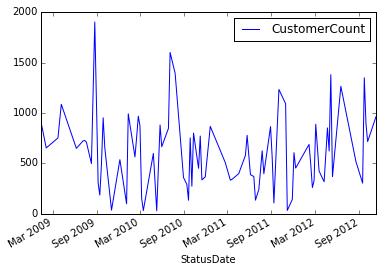

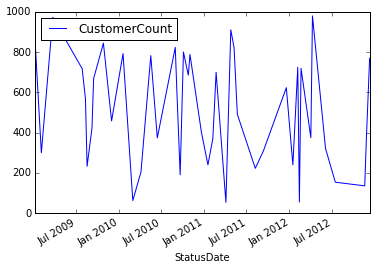

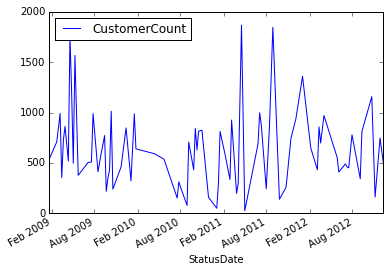

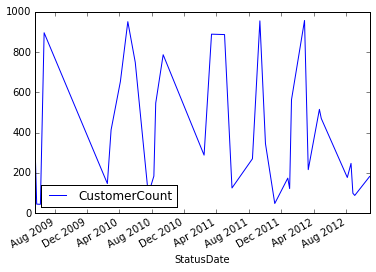

In [115]:
Daily.loc['FL'].plot()
Daily.loc['GA'].plot()
Daily.loc['NY'].plot()
Daily.loc['TX'].plot();

We can also just plot the data on a specific date, like ***2012***. We can now clearly see that the data for these states is all over the place. since the data consist of weekly customer counts, the variability of the data seems suspect. For this tutorial we will assume bad data and proceed. 

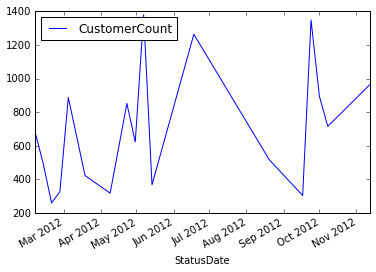

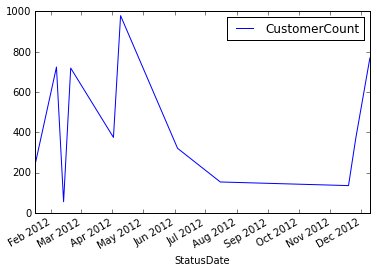

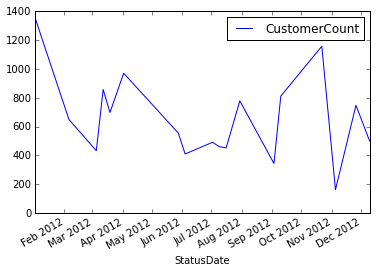

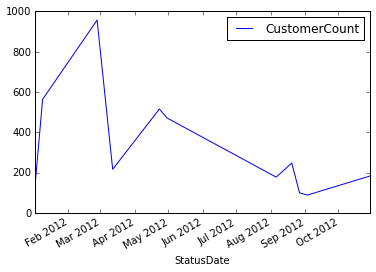

In [116]:
Daily.loc['FL']['2012':].plot()
Daily.loc['GA']['2012':].plot()
Daily.loc['NY']['2012':].plot()
Daily.loc['TX']['2012':].plot();

We will assume that per month the customer count should remain relatively steady. Any data outside a specific range in that month will be removed from the data set. The final result should have smooth graphs with no spikes.  

***StateYearMonth*** - Here we group by State, Year of StatusDate, and Month of StatusDate.  
***Daily['Outlier']*** - A boolean (True or False) value letting us know if the value in the CustomerCount column is ouside the acceptable range.  

We will be using the attribute ***transform*** instead of ***apply***. The reason is that transform will keep the shape(# of rows and columns) of the dataframe the same and apply will not. By looking at the previous graphs, we can realize they are not resembling a gaussian distribution, this means we cannot use summary statistics like the mean and stDev. We use percentiles instead. Note that we run the risk of eliminating good data.

In [117]:
# Calculate Outliers
StateYearMonth = Daily.groupby([Daily.index.get_level_values(0), Daily.index.get_level_values(1).year, Daily.index.get_level_values(1).month])
Daily['Lower'] = StateYearMonth['CustomerCount'].transform( lambda x: x.quantile(q=.25) - (1.5*x.quantile(q=.75)-x.quantile(q=.25)) )
Daily['Upper'] = StateYearMonth['CustomerCount'].transform( lambda x: x.quantile(q=.75) + (1.5*x.quantile(q=.75)-x.quantile(q=.25)) )
Daily['Outlier'] = (Daily['CustomerCount'] < Daily['Lower']) | (Daily['CustomerCount'] > Daily['Upper']) 

# Remove Outliers
Daily = Daily[Daily['Outlier'] == False]

In [118]:
type(StateYearMonth['CustomerCount'])

pandas.core.groupby.SeriesGroupBy

The dataframe named ***Daily*** will hold customer counts that have been aggregated per day. The original data (df) has multiple records per day.  We are left with a data set that is indexed by both the state and the StatusDate. The Outlier column should be equal to ***False*** signifying that the record is not an outlier.

In [119]:
Daily.head()

CustomerCount  Lower   Upper Outlier
State StatusDate                                      
FL    2009-01-12            901  450.5  1351.5   False
      2009-02-02            653  326.5   979.5   False
      2009-03-23            752  376.0  1128.0   False
      2009-04-06           1086  543.0  1629.0   False
      2009-06-08            649  324.5   973.5   False

We create a separate dataframe named ***ALL*** which groups the Daily dataframe by StatusDate. We are essentially getting rid of the ***State*** column. The ***Max*** column represents the maximum customer count per month. The ***Max*** column is used to smooth out the graph.

In [120]:
# Combine all markets

# Get the max customer count by Date
ALL = pd.DataFrame(Daily['CustomerCount'].groupby(Daily.index.get_level_values(1)).sum())
ALL.columns = ['CustomerCount'] # rename column

# Group by Year and Month
YearMonth = ALL.groupby([lambda x: x.year, lambda x: x.month])

# What is the max customer count per Year and Month
ALL['Max'] = YearMonth['CustomerCount'].transform(lambda x: x.max())
ALL.head()

,CustomerCount,Max
StatusDate,,
2009-01-05,877,901
2009-01-12,901,901
2009-01-19,522,901
2009-02-02,953,953
2009-02-23,710,953


As you can see from the ***ALL*** dataframe above, in the month of January 2009, the maximum customer count was 901. If we had used ***apply***, we would have got a dataframe with (Year and Month) as the index and just the *Max* column with the value of 901. 

----------------------------------  
There is also an interest to gauge if the current customer counts were reaching certain goals the company had established. The task here is to visually show if the current customer counts are meeting the goals listed below. We will call the goals ***BHAG*** (Big Hairy Annual Goal).  

* 12/31/2011 - 1,000 customers  
* 12/31/2012 - 2,000 customers  
* 12/31/2013 - 3,000 customers  

We will be using the **date_range** function to create our dates.  

***Definition:*** date_range(start=None, end=None, periods=None, freq='D', tz=None, normalize=False, name=None, closed=None)  
***Docstring:*** Return a fixed frequency datetime index, with day (calendar) as the default frequency  

By choosing the frequency to be ***A*** or annual we will be able to get the three target dates from above.

In [121]:
date_range?

Object `date_range` not found.


In [122]:
# Create the BHAG dataframe
data = [1000,2000,3000]
idx = pd.date_range(start='12/31/2011', end='12/31/2013', freq='A')
BHAG = pd.DataFrame(data, index=idx, columns=['BHAG'])
BHAG

,BHAG
2011-12-31,1000
2012-12-31,2000
2013-12-31,3000


Combining dataframes as we have learned in previous lesson is made simple using the ***concat*** function. Remember when we choose ***axis = 0*** we are appending row wise.

In [123]:
# Combine the BHAG and the ALL data set 
combined = pd.concat([ALL,BHAG], axis=0)
combined = combined.sort(axis=0)
combined.tail()

,BHAG,CustomerCount,Max
2012-11-19,NaN,136,1115
2012-11-26,NaN,1115,1115
2012-12-10,NaN,1269,1269
2012-12-31,2000,NaN,NaN
2013-12-31,3000,NaN,NaN


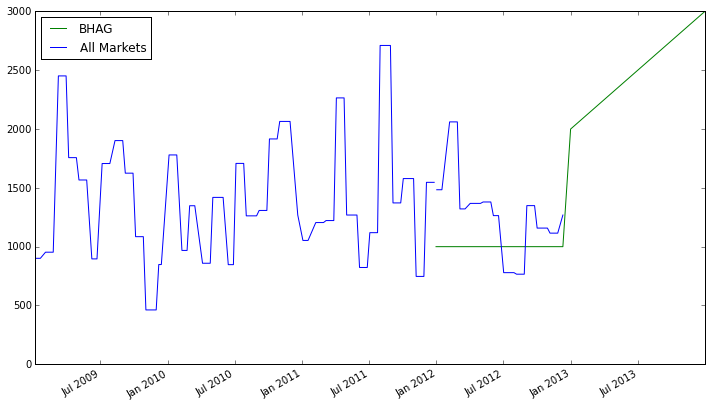

In [124]:
fig, axes = plt.subplots(figsize=(12, 7))

combined['BHAG'].fillna(method='pad').plot(color='green', label='BHAG')
combined['Max'].plot(color='blue', label='All Markets')
plt.legend(loc='best');

There was also a need to forecast next year's customer count and we can do this in a couple of simple steps. We will first group the ***combined*** dataframe by ***Year*** and place the maximum customer count for that year. This will give us one row per Year.   

In [125]:
# Group by Year and then get the max value per year
Year = combined.groupby(lambda x: x.year).max()
Year

,BHAG,CustomerCount,Max
2009,NaN,2452,2452
2010,NaN,2065,2065
2011,1000,2711,2711
2012,2000,2061,2061
2013,3000,NaN,NaN


In [126]:
# Add a column representing the percent change per year
Year['YR_PCT_Change'] = Year['Max'].pct_change(periods=1)
Year

,BHAG,CustomerCount,Max,YR_PCT_Change
2009,NaN,2452,2452,NaN
2010,NaN,2065,2065,-0.157830
2011,1000,2711,2711,0.312833
2012,2000,2061,2061,-0.239764
2013,3000,NaN,NaN,NaN


To get next year's end customer count we will assume our current growth rate remains constant. We then will increase this years customer count by that amount and that will be our forecast for next year. 

In [127]:
(1 + Year.ix[2012,'YR_PCT_Change']) * Year.ix[2012,'Max']

1566.8465510881595

# Present Data  

Create individual Graphs per State.  

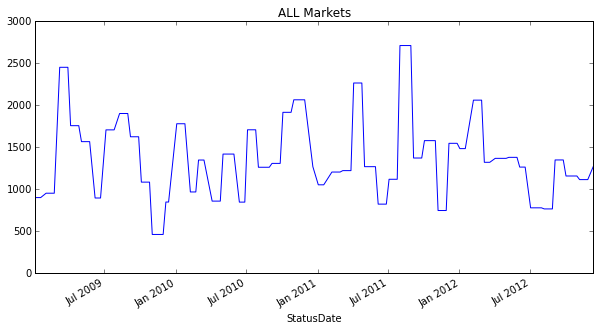

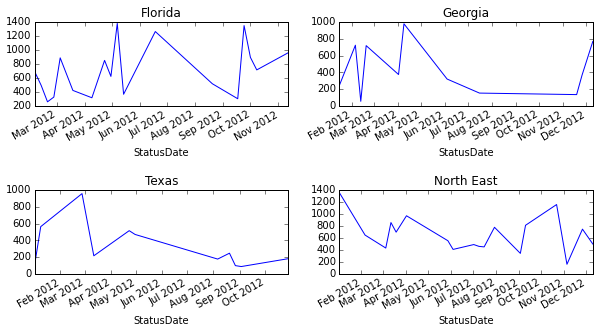

In [128]:
# First Graph
ALL['Max'].plot(figsize=(10, 5));plt.title('ALL Markets')

# Last four Graphs
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 5))
fig.subplots_adjust(hspace=1.0) ## Create space between plots

Daily.loc['FL']['CustomerCount']['2012':].fillna(method='pad').plot(ax=axes[0,0])
Daily.loc['GA']['CustomerCount']['2012':].fillna(method='pad').plot(ax=axes[0,1]) 
Daily.loc['TX']['CustomerCount']['2012':].fillna(method='pad').plot(ax=axes[1,0]) 
Daily.loc['NY']['CustomerCount']['2012':].fillna(method='pad').plot(ax=axes[1,1]) 

# Add titles
axes[0,0].set_title('Florida')
axes[0,1].set_title('Georgia')
axes[1,0].set_title('Texas')
axes[1,1].set_title('North East');

**Author:** [David Rojas](http://www.hedaro.com/)  